In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2

# below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser)

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

## Cohort selection

### Identifying patients with AKI from ICD-9 codes

In [3]:
query = query_schema + """
SELECT diag.subject_id, diag.hadm_id, diag.icd9_code, icu.icustay_id
FROM diagnoses_icd diag
INNER JOIN icustays icu
    ON diag.hadm_id = icu.hadm_id
WHERE diag.icd9_code LIKE '584%%'
"""
df = pd.read_sql_query(query, con)
df['icd9_code'].value_counts()

5849    10108
5845     2751
5848       68
5846        6
5847        3
Name: icd9_code, dtype: int64

**Limits of this method :**
The diagnoses_icd table is used for billing - for this reason, we just have as information the order of priority of each diagnosis for a given patient/admission. But we don't have a timestamp allowing to know when a certain diagnosis was made. In particular, we can't extract information about the moment when the AKI came. With this method we would filter on patients based on their diagnosis but won't be able to filter on creatinine measurements (and include only the ones that came AFTER the AKI)

### With creatinine and urine

### Number of ICU stays with AKI according to 48hr/7day KDIGO criteria

In [17]:
# Number of ICU stays with patient being in AKI from the 48h-criteria
query = query_schema + """
select
    AKI_48hr
  from kdigo_stages_48hr
"""
df = pd.read_sql_query(query, con)
print("Number of ICU stays with patient being in AKI from the 48h-criteria : ")
print(df['aki_48hr'].sum())

# Number of ICU stays with patient being in AKI from the 7d-criteria
query = query_schema + """
select
    AKI_7day
  from kdigo_stages_7day
"""
df = pd.read_sql_query(query, con)
print("Number of ICU stays with patient being in AKI from the 7days-criteria : ")
print(df['aki_7day'].sum())

Number of ICU stays with patient being in AKI from the 48h-criteria : 
22375.0
Number of ICU stays with patient being in AKI from the 7days-criteria : 
32611.0


### Explore materialized view "kdigo_stages_48h"

List of columns : 
   schema_name         table_name               column_name   datatype
0     mimiciii  kdigo_stages_48hr                icustay_id       int4
1     mimiciii  kdigo_stages_48hr                  aki_48hr       int4
2     mimiciii  kdigo_stages_48hr            aki_stage_48hr       int4
3     mimiciii  kdigo_stages_48hr      aki_stage_48hr_creat       int4
4     mimiciii  kdigo_stages_48hr         aki_stage_48hr_uo       int4
5     mimiciii  kdigo_stages_48hr              lowcreat48hr     float8
6     mimiciii  kdigo_stages_48hr             highcreat48hr     float8
7     mimiciii  kdigo_stages_48hr   lowcreat48hrtimeelapsed    numeric
8     mimiciii  kdigo_stages_48hr  highcreat48hrtimeelapsed    numeric
9     mimiciii  kdigo_stages_48hr          lowcreat48hrtime  timestamp
10    mimiciii  kdigo_stages_48hr         highcreat48hrtime  timestamp
11    mimiciii  kdigo_stages_48hr                  uo6_48hr    numeric
12    mimiciii  kdigo_stages_48hr                 uo12_48h

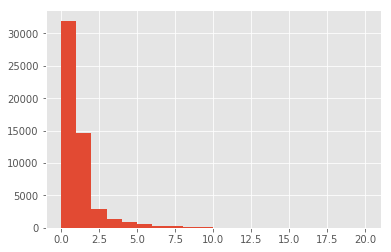

Distribution of highest creatinine values : 


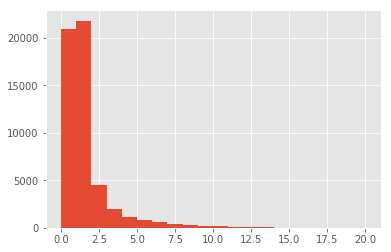

Time elapsed since lowest creatinine : 


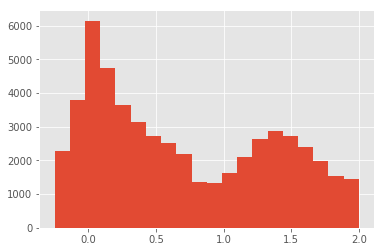

Time elapsed since highest creatinine : 


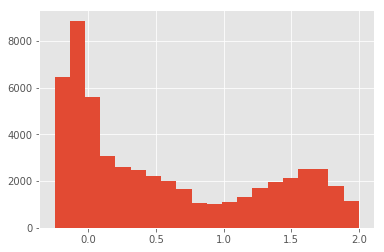

Urinary output (6) : 


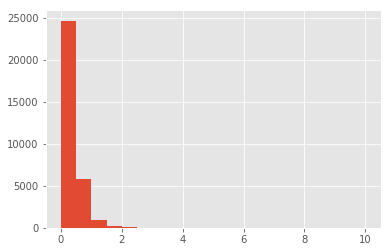

Urinary output (12) : 


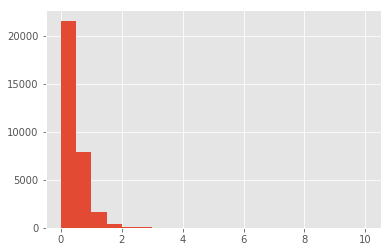

Urinary output (24) : 


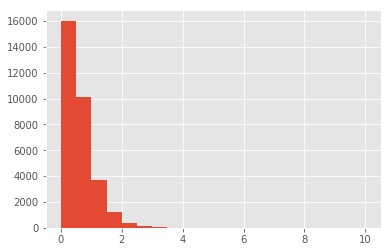

In [49]:
# Explore materialized view "kdigo_stages_48h"
query = query_schema + """
select 
    ns.nspname as schema_name, 
    cls.relname as table_name, 
    attr.attname as column_name,
    trim(leading '_' from tp.typname) as datatype
from pg_catalog.pg_attribute as attr
join pg_catalog.pg_class as cls on cls.oid = attr.attrelid
join pg_catalog.pg_namespace as ns on ns.oid = cls.relnamespace
join pg_catalog.pg_type as tp on tp.typelem = attr.atttypid
where 
    ns.nspname = 'mimiciii' and
    cls.relname = 'kdigo_stages_48hr' and 
    not attr.attisdropped and 
    cast(tp.typanalyze as text) = 'array_typanalyze' and 
    attr.attnum > 0
order by 
    attr.attnum
"""
df = pd.read_sql_query(query, con)
print('List of columns : ')
print(df)

# Explore materialized view "kdigo_stages_48h"
query = query_schema + """
select *
from kdigo_stages_48hr
"""
df = pd.read_sql_query(query, con)
print('Kdigo 48hr table : ')
print(df.shape)

print('Distribution of lowest creatinine values : ')
df['lowcreat48hr'].hist(bins=20, range=(0,20))
plt.show()
print('Distribution of highest creatinine values : ')
df['highcreat48hr'].hist(bins=20, range=(0,20))
plt.show()

print('Time elapsed since lowest creatinine : ')
df['lowcreat48hrtimeelapsed'].hist(bins=20)
plt.show()
print('Time elapsed since highest creatinine : ')
df['highcreat48hrtimeelapsed'].hist(bins=20)
plt.show()

print('Urinary output (6) : ')
df['uo6_48hr'].hist(bins=20, range=(0,10))
plt.show()
print('Urinary output (12) : ')
df['uo12_48hr'].hist(bins=20, range=(0,10))
plt.show()
print('Urinary output (24) : ')
df['uo24_48hr'].hist(bins=20, range=(0,10))
plt.show()

### Explore materialized view "kdigo_stages_7day"

List of columns : 
   schema_name         table_name               column_name   datatype
0     mimiciii  kdigo_stages_7day                icustay_id       int4
1     mimiciii  kdigo_stages_7day                  aki_7day       int4
2     mimiciii  kdigo_stages_7day            aki_stage_7day       int4
3     mimiciii  kdigo_stages_7day      aki_stage_7day_creat       int4
4     mimiciii  kdigo_stages_7day              lowcreat7day     float8
5     mimiciii  kdigo_stages_7day             highcreat7day     float8
6     mimiciii  kdigo_stages_7day   lowcreat7daytimeelapsed    numeric
7     mimiciii  kdigo_stages_7day  highcreat7daytimeelapsed    numeric
8     mimiciii  kdigo_stages_7day          lowcreat7daytime  timestamp
9     mimiciii  kdigo_stages_7day         highcreat7daytime  timestamp
10    mimiciii  kdigo_stages_7day                  uo6_48hr    numeric
11    mimiciii  kdigo_stages_7day                 uo12_48hr    numeric
12    mimiciii  kdigo_stages_7day                 uo24_48h

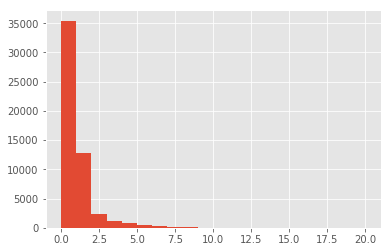

Distribution of highest creatinine values : 


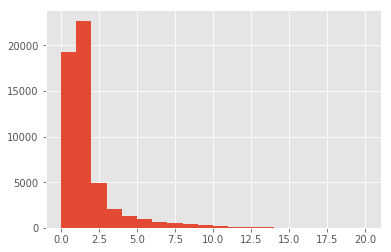

Time elapsed since lowest creatinine : 


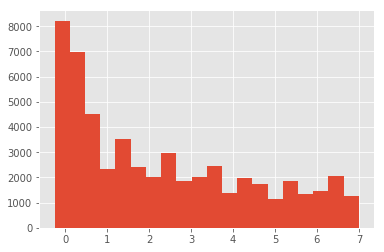

Time elapsed since highest creatinine : 


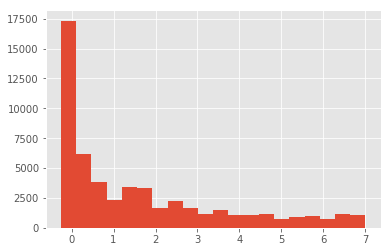

Urinary output (6) : 


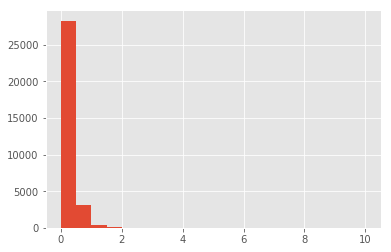

Urinary output (12) : 


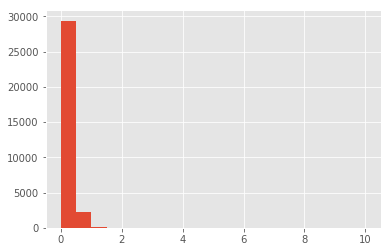

Urinary output (24) : 


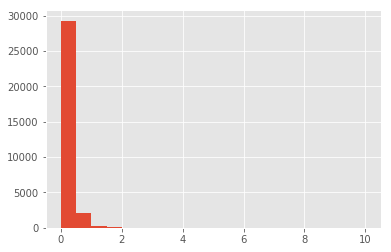

In [48]:
# Explore columns of materialized view "kdigo_stages_7day"
query = query_schema + """
select 
    ns.nspname as schema_name, 
    cls.relname as table_name, 
    attr.attname as column_name,
    trim(leading '_' from tp.typname) as datatype
from pg_catalog.pg_attribute as attr
join pg_catalog.pg_class as cls on cls.oid = attr.attrelid
join pg_catalog.pg_namespace as ns on ns.oid = cls.relnamespace
join pg_catalog.pg_type as tp on tp.typelem = attr.atttypid
where 
    ns.nspname = 'mimiciii' and
    cls.relname = 'kdigo_stages_7day' and 
    not attr.attisdropped and 
    cast(tp.typanalyze as text) = 'array_typanalyze' and 
    attr.attnum > 0
order by 
    attr.attnum
"""
df = pd.read_sql_query(query, con)
print('List of columns : ')
print(df)

# Explore materialized view "kdigo_stages_7day"
query = query_schema + """
select *
from kdigo_stages_7day
"""
df = pd.read_sql_query(query, con)
print('Kdigo 7day table : ')
print(df.shape)

print('Distribution of lowest creatinine values : ')
df['lowcreat7day'].hist(bins=20, range=(0,20))
plt.show()
print('Distribution of highest creatinine values : ')
df['highcreat7day'].hist(bins=20, range=(0,20))
plt.show()

print('Time elapsed since lowest creatinine : ')
df['lowcreat7daytimeelapsed'].hist(bins=20)
plt.show()
print('Time elapsed since highest creatinine : ')
df['highcreat7daytimeelapsed'].hist(bins=20)
plt.show()

print('Urinary output (6) : ')
df['uo6_48hr'].hist(bins=20, range=(0,10))
plt.show()
print('Urinary output (12) : ')
df['uo12_48hr'].hist(bins=20, range=(0,10))
plt.show()
print('Urinary output (24) : ')
df['uo24_48hr'].hist(bins=20, range=(0,10))
plt.show()

### Query to get icustay_id + all measurements of creatinine of patients with AKI according to kdigo_7days, excluding measurements performed under CRRT
** remark : CRRT is a particular case of dialysis, it might not cover all the situations that we want to exclude ! Maybe it would be better (if we get enough data) to just exclude patients that are under RRT according to the rrt table (created from concepts/rrt.sql). **

In [3]:
query = query_schema + """
with aki_cr as
(
select
    ie.icustay_id, ie.intime, ie.outtime,
    le.valuenum as creatinine, le.charttime as creatinine_time,
    kdigo.aki_7day, kdigo.aki_stage_7day
  from icustays ie
  inner join labevents le
    on ie.subject_id = le.subject_id
    and le.itemid = 50912
    and le.valuenum is not null
    and le.charttime between ie.intime and ie.outtime
  inner join kdigo_stages_7day kdigo
    on ie.icustay_id = kdigo.icustay_id
    and kdigo.aki_7day=1.0
)
select aki_cr.icustay_id, aki_cr.intime, aki_cr.outtime, aki_cr.creatinine, aki_cr.creatinine_time, aki_cr.aki_7day, aki_cr.aki_stage_7day,
    crrt.starttime as crrt_start, crrt.endtime as crrt_end
  from aki_cr
  left join crrtdurations crrt
    on aki_cr.icustay_id = crrt.icustay_id
    and creatinine_time not between crrt.starttime and crrt.endtime
  
"""
df = pd.read_sql_query(query, con)
df

,icustay_id,intime,outtime,creatinine,creatinine_time,aki_7day,aki_stage_7day,crrt_start,crrt_end
0,280836,2198-02-14 23:27:38,2198-02-18 05:26:11,3.6,2198-02-16 20:50:00,1,3,NaT,NaT
1,280836,2198-02-14 23:27:38,2198-02-18 05:26:11,3.8,2198-02-17 02:57:00,1,3,NaT,NaT
2,280836,2198-02-14 23:27:38,2198-02-18 05:26:11,2.5,2198-02-15 01:24:00,1,3,NaT,NaT
3,280836,2198-02-14 23:27:38,2198-02-18 05:26:11,2.8,2198-02-15 05:44:00,1,3,NaT,NaT
4,280836,2198-02-14 23:27:38,2198-02-18 05:26:11,2.7,2198-02-15 17:30:00,1,3,NaT,NaT
5,280836,2198-02-14 23:27:38,2198-02-18 05:26:11,3.3,2198-02-16 04:00:00,1,3,NaT,NaT
6,206613,2170-11-05 11:05:29,2170-11-08 17:46:57,0.6,2170-11-05 13:05:00,1,3,NaT,NaT
7,206613,2170-11-05 11:05:29,2170-11-08 17:46:57,0.5,2170-11-05 20:03:00,1,3,NaT,NaT
8,206613,2170-11-05 11:05:29,2170-11-08 17:46:57,0.6,2170-11-06 01:45:00,1,3,NaT,NaT
9,206613,2170-11-05 11:05:29,2170-11-08 17:46:57,0.5,2170-11-06 15:11:00,1,3,NaT,NaT


WARNING : this query returns duplicate measurements of creatinine for icustays during which there were several CRRT. This has to be filtered afterwards in Pandas.

In [4]:
print('Number of distinct creatinine measurements :')
print(df.drop_duplicates('creatinine_time').shape[0])

Number of distinct creatinine measurements :
255596


### Other method : exclude all patients that have received RRT according to the rrt table

In [4]:
query = query_schema + """
with aki_cr as
(
select
    ie.icustay_id, ie.intime, ie.outtime,
    le.valuenum as creatinine, le.charttime as creatinine_time,
    kdigo.aki_7day, kdigo.aki_stage_7day
  from icustays ie
  inner join labevents le
    on ie.subject_id = le.subject_id
    and le.itemid = 50912
    and le.valuenum is not null
    and le.charttime between ie.intime and ie.outtime
  inner join kdigo_stages_7day kdigo
    on ie.icustay_id = kdigo.icustay_id
    and kdigo.aki_7day=1.0
)
select aki_cr.icustay_id, aki_cr.intime, aki_cr.outtime, aki_cr.creatinine, aki_cr.creatinine_time, aki_cr.aki_7day, aki_cr.aki_stage_7day
  from aki_cr
  left outer join rrt 
    on aki_cr.icustay_id = rrt.icustay_id
    and rrt.icustay_id is null
  
"""
df = pd.read_sql_query(query, con)
df

,icustay_id,intime,outtime,creatinine,creatinine_time,aki_7day,aki_stage_7day
0,280836,2198-02-14 23:27:38,2198-02-18 05:26:11,3.6,2198-02-16 20:50:00,1,3
1,280836,2198-02-14 23:27:38,2198-02-18 05:26:11,3.8,2198-02-17 02:57:00,1,3
2,280836,2198-02-14 23:27:38,2198-02-18 05:26:11,2.5,2198-02-15 01:24:00,1,3
3,280836,2198-02-14 23:27:38,2198-02-18 05:26:11,2.8,2198-02-15 05:44:00,1,3
4,280836,2198-02-14 23:27:38,2198-02-18 05:26:11,2.7,2198-02-15 17:30:00,1,3
5,280836,2198-02-14 23:27:38,2198-02-18 05:26:11,3.3,2198-02-16 04:00:00,1,3
6,206613,2170-11-05 11:05:29,2170-11-08 17:46:57,0.6,2170-11-05 13:05:00,1,3
7,206613,2170-11-05 11:05:29,2170-11-08 17:46:57,0.5,2170-11-05 20:03:00,1,3
8,206613,2170-11-05 11:05:29,2170-11-08 17:46:57,0.6,2170-11-06 01:45:00,1,3
9,206613,2170-11-05 11:05:29,2170-11-08 17:46:57,0.5,2170-11-06 15:11:00,1,3


In [5]:
print('Number of distinct creatinine measurements :')
print(df.drop_duplicates('creatinine_time').shape[0])

Number of distinct creatinine measurements :
255596


In [6]:
df = df.drop_duplicates('creatinine_time')
df.to_csv('creatinine_measurements.csv')

** We have the same number of measurements with this method --> use this latter to get the creatinine !**
** TODO : ADD IN THE QUERY JOIN WITH OTHER TABLES TO GET SOME FEATURES**

### Drop duplicates of creatinine measurements and create labels

In [112]:
# To be implemented

print(df.loc[df['crrt_start'].notnull(),['creatinine_time','crrt_start','crrt_end']])

           creatinine_time          crrt_start            crrt_end
427    2174-01-09 20:42:00 2174-01-13 01:30:00 2174-01-13 11:00:00
428    2174-01-09 20:42:00 2174-01-12 07:00:00 2174-01-13 01:00:00
429    2174-01-09 20:42:00 2174-01-11 15:00:00 2174-01-12 06:00:00
430    2174-01-09 20:42:00 2174-01-10 23:30:00 2174-01-11 14:00:00
431    2174-01-09 20:42:00 2174-01-10 06:00:00 2174-01-10 23:00:00
432    2174-01-09 20:42:00 2174-01-10 01:00:00 2174-01-10 05:15:00
433    2174-01-10 02:45:00 2174-01-13 01:30:00 2174-01-13 11:00:00
434    2174-01-10 02:45:00 2174-01-12 07:00:00 2174-01-13 01:00:00
435    2174-01-10 02:45:00 2174-01-11 15:00:00 2174-01-12 06:00:00
436    2174-01-10 02:45:00 2174-01-10 23:30:00 2174-01-11 14:00:00
437    2174-01-10 02:45:00 2174-01-10 06:00:00 2174-01-10 23:00:00
438    2174-01-10 02:45:00 2174-01-09 20:00:00 2174-01-10 00:00:00
439    2174-01-10 08:16:00 2174-01-13 01:30:00 2174-01-13 11:00:00
440    2174-01-10 08:16:00 2174-01-12 07:00:00 2174-01-13 01:0

In [57]:
print(df.sort_values(by='icustay_id'))

        icustay_id              intime             outtime  creat  \
204078      200001 2181-11-25 19:06:12 2181-11-28 20:59:25    3.3   
204073      200001 2181-11-25 19:06:12 2181-11-28 20:59:25    2.7   
204074      200001 2181-11-25 19:06:12 2181-11-28 20:59:25    3.5   
204075      200001 2181-11-25 19:06:12 2181-11-28 20:59:25    2.9   
204076      200001 2181-11-25 19:06:12 2181-11-28 20:59:25    4.4   
204077      200001 2181-11-25 19:06:12 2181-11-28 20:59:25    4.7   
204079      200001 2181-11-25 19:06:12 2181-11-28 20:59:25    3.9   
142065      200003 2199-08-02 19:50:04 2199-08-08 17:09:18    0.7   
142066      200003 2199-08-02 19:50:04 2199-08-08 17:09:18    0.7   
142062      200003 2199-08-02 19:50:04 2199-08-08 17:09:18    0.7   
142067      200003 2199-08-02 19:50:04 2199-08-08 17:09:18    0.6   
142064      200003 2199-08-02 19:50:04 2199-08-08 17:09:18    0.7   
142061      200003 2199-08-02 19:50:04 2199-08-08 17:09:18    0.7   
142059      200003 2199-08-02 19:5

## Explore materialized view RRT

### Attention : utiliser la table rrtfirstday (=info si le patient était en RRT au premier jour de son passage en réa) ou crrtdurations (timestamp et durée disponibles mais seulement pour les "continuousRRT") ?

In [63]:
# Explore materialized view "rrtfirstday"
query = query_schema + """
select 
    ns.nspname as schema_name, 
    cls.relname as table_name, 
    attr.attname as column_name,
    trim(leading '_' from tp.typname) as datatype
from pg_catalog.pg_attribute as attr
join pg_catalog.pg_class as cls on cls.oid = attr.attrelid
join pg_catalog.pg_namespace as ns on ns.oid = cls.relnamespace
join pg_catalog.pg_type as tp on tp.typelem = attr.atttypid
where 
    ns.nspname = 'mimiciii' and
    cls.relname = 'rrtfirstday' and 
    not attr.attisdropped and 
    cast(tp.typanalyze as text) = 'array_typanalyze' and 
    attr.attnum > 0
order by 
    attr.attnum
"""
df = pd.read_sql_query(query, con)
print('List of columns : ')
print(df)

# Explore materialized view "rrtfirstday"
query = query_schema + """
select *
from rrtfirstday
"""
df = pd.read_sql_query(query, con)
print('rrtfirstday table : ')
print(df.shape)

print('Possible values for RRT on first day : ')
df['rrt'].value_counts()

List of columns : 
  schema_name   table_name column_name datatype
0    mimiciii  rrtfirstday  subject_id     int4
1    mimiciii  rrtfirstday     hadm_id     int4
2    mimiciii  rrtfirstday  icustay_id     int4
3    mimiciii  rrtfirstday         rrt     int4
rrtfirstday table : 
(61532, 4)
Possible values for RRT on first day : 


0    59181
1     2351
Name: rrt, dtype: int64

List of columns : 
  schema_name     table_name     column_name   datatype
0    mimiciii  crrtdurations      icustay_id       int4
1    mimiciii  crrtdurations             num       int8
2    mimiciii  crrtdurations       starttime  timestamp
3    mimiciii  crrtdurations         endtime  timestamp
4    mimiciii  crrtdurations  duration_hours     float8
crrtdurations table : 
(5918, 5)
Number of CRRT for a given patient/stay: 


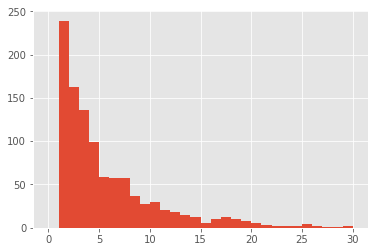

0      2120-03-25 04:00:00
1      2120-03-26 02:15:00
2      2120-03-26 06:30:00
3      2120-03-27 07:00:00
4      2120-03-28 12:00:00
5      2120-03-29 11:00:00
6      2120-03-30 09:30:00
7      2120-03-31 08:30:00
8      2120-03-31 11:45:00
9      2120-04-01 05:30:00
10     2163-04-16 12:00:00
11     2193-06-20 05:00:00
12     2193-06-20 10:00:00
13     2193-06-21 00:00:00
14     2193-06-21 15:00:00
15     2193-06-22 14:00:00
16     2193-06-22 23:30:00
17     2193-06-23 10:00:00
18     2193-06-23 20:15:00
19     2193-06-24 07:00:00
20     2193-06-24 21:30:00
21     2193-06-25 06:15:00
22     2193-06-25 18:00:00
23     2193-06-25 22:00:00
24     2193-06-26 07:00:00
25     2193-06-26 19:00:00
26     2193-06-27 04:10:00
27     2193-06-27 13:00:00
28     2135-04-30 00:00:00
29     2135-04-30 11:00:00
               ...        
5888   2112-03-13 23:00:00
5889   2112-03-15 08:00:00
5890   2194-11-07 09:00:00
5891   2196-10-05 13:00:00
5892   2149-12-26 22:00:00
5893   2149-12-27 06:00:00
5

In [77]:
# Explore materialized view "crrtdurations"
query = query_schema + """
select 
    ns.nspname as schema_name, 
    cls.relname as table_name, 
    attr.attname as column_name,
    trim(leading '_' from tp.typname) as datatype
from pg_catalog.pg_attribute as attr
join pg_catalog.pg_class as cls on cls.oid = attr.attrelid
join pg_catalog.pg_namespace as ns on ns.oid = cls.relnamespace
join pg_catalog.pg_type as tp on tp.typelem = attr.atttypid
where 
    ns.nspname = 'mimiciii' and
    cls.relname = 'crrtdurations' and 
    not attr.attisdropped and 
    cast(tp.typanalyze as text) = 'array_typanalyze' and 
    attr.attnum > 0
order by 
    attr.attnum
"""
df = pd.read_sql_query(query, con)
print('List of columns : ')
print(df)

# Explore materialized view "crrtdurations"
query = query_schema + """
select *
from crrtdurations
"""
df = pd.read_sql_query(query, con)
print('crrtdurations table : ')
print(df.shape)

print('Number of CRRT for a given patient/stay: ')
df.groupby('icustay_id')['duration_hours'].count().hist(bins=30, range=(0,30))
plt.show()

print(df['endtime'])

### Explore rrt (from rrt.sql) <-- le plus simple est d'exclure tous les icustay_id qui sont dans cette table

In [116]:
# Explore materialized view "rrt"
query = query_schema + """
select 
    ns.nspname as schema_name, 
    cls.relname as table_name, 
    attr.attname as column_name,
    trim(leading '_' from tp.typname) as datatype
from pg_catalog.pg_attribute as attr
join pg_catalog.pg_class as cls on cls.oid = attr.attrelid
join pg_catalog.pg_namespace as ns on ns.oid = cls.relnamespace
join pg_catalog.pg_type as tp on tp.typelem = attr.atttypid
where 
    ns.nspname = 'mimiciii' and
    cls.relname = 'rrt' and 
    not attr.attisdropped and 
    cast(tp.typanalyze as text) = 'array_typanalyze' and 
    attr.attnum > 0
order by 
    attr.attnum
"""
df = pd.read_sql_query(query, con)
print('List of columns : ')
print(df)

# Explore materialized view "rrtfirstday"
query = query_schema + """
select *
from rrt
"""
df = pd.read_sql_query(query, con)
print('rrtfirstday table : ')
print(df.shape)

print('Possible values for RRT on first day : ')
df['rrt'].value_counts()

List of columns : 
  schema_name table_name column_name datatype
0    mimiciii        rrt  subject_id     int4
1    mimiciii        rrt     hadm_id     int4
2    mimiciii        rrt  icustay_id     int4
3    mimiciii        rrt         rrt     int4
rrtfirstday table : 
(61532, 4)
Possible values for RRT on first day : 


0    59181
1     2351
Name: rrt, dtype: int64

### Copy-paste from https://github.com/MIT-LCP/mimic-code/blob/master/concepts/organfailure/kdigo-creatinine.sql

In [55]:
query = query_schema + """
DROP MATERIALIZED VIEW IF EXISTS kdigo_creat CASCADE;
CREATE MATERIALIZED VIEW kdigo_creat as
-- Extract all creatinine values from labevents around patient's ICU stay
with cr as
(
select
    ie.icustay_id
  , ie.intime, ie.outtime
  , le.valuenum as creat
  , le.charttime
  from icustays ie
  left join labevents le
    on ie.subject_id = le.subject_id
    and le.ITEMID = 50912
    and le.VALUENUM is not null
    and le.CHARTTIME between (ie.intime - interval '6' hour) and (ie.intime + interval '7' day)
)
-- ***** --
-- Get the highest and lowest creatinine for the first 48 hours of ICU admission
-- also get the first creatinine
-- ***** --
, cr_48hr as
(
select
    cr.icustay_id
  , cr.creat
  , cr.charttime
  -- Create an index that goes from 1, 2, ..., N
  -- The index represents how early in the patient's stay a creatinine value was measured
  -- Consequently, when we later select index == 1, we only select the first (admission) creatinine
  -- In addition, we only select the first stay for the given subject_id
  , ROW_NUMBER ()
          OVER (PARTITION BY cr.icustay_id
                ORDER BY cr.charttime
              ) as rn_first

  -- Similarly, we can get the highest and the lowest creatinine by ordering by VALUENUM
  , ROW_NUMBER ()
          OVER (PARTITION BY cr.icustay_id
                ORDER BY cr.creat DESC
              ) as rn_highest
  , ROW_NUMBER ()
          OVER (PARTITION BY cr.icustay_id
                ORDER BY cr.creat
              ) as rn_lowest
  from cr
  -- limit to the first 48 hours (source table has data up to 7 days)
  where cr.charttime <= cr.intime + interval '48' hour
)
-- ***** --
-- Get the highest and lowest creatinine for the first 7 days of ICU admission
-- ***** --
, cr_7day as
(
select
    cr.icustay_id
  , cr.creat
  , cr.charttime
  -- We can get the highest and the lowest creatinine by ordering by VALUENUM
  , ROW_NUMBER ()
          OVER (PARTITION BY cr.icustay_id
                ORDER BY cr.creat DESC
              ) as rn_highest
  , ROW_NUMBER ()
          OVER (PARTITION BY cr.icustay_id
                ORDER BY cr.creat
              ) as rn_lowest
  from cr
)
-- ***** --
-- Final query
-- ***** --
select
    ie.subject_id, ie.hadm_id, ie.icustay_id
  , cr_48hr_admit.creat as AdmCreat
  , cr_48hr_admit.charttime as AdmCreatTime
  , cr_48hr_low.creat as LowCreat48hr
  , cr_48hr_low.charttime as LowCreat48hrTime
  , cr_48hr_high.creat as HighCreat48hr
  , cr_48hr_high.charttime as HighCreat48hrTime

  , cr_7day_low.creat as LowCreat7day
  , cr_7day_low.charttime as LowCreat7dayTime
  , cr_7day_high.creat as HighCreat7day
  , cr_7day_high.charttime as HighCreat7dayTime

from icustays ie
left join cr_48hr cr_48hr_admit
  on ie.icustay_id = cr_48hr_admit.icustay_id
  and cr_48hr_admit.rn_first = 1
left join cr_48hr cr_48hr_high
  on ie.icustay_id = cr_48hr_high.icustay_id
  and cr_48hr_high.rn_highest = 1
left join cr_48hr cr_48hr_low
  on ie.icustay_id = cr_48hr_low.icustay_id
  and cr_48hr_low.rn_lowest = 1
left join cr_7day cr_7day_high
  on ie.icustay_id = cr_7day_high.icustay_id
  and cr_7day_high.rn_highest = 1
left join cr_7day cr_7day_low
  on ie.icustay_id = cr_7day_low.icustay_id
  and cr_7day_low.rn_lowest = 1
order by ie.icustay_id;
"""
df = pd.read_sql_query(query, con)
df

TypeError: 'NoneType' object is not iterable

## PLAYGROUND

In [3]:
query = query_schema + """
SELECT subject_id, hadm_id, icustay_id
FROM icustays
LIMIT 10
"""
df = pd.read_sql_query(query, con)
df.head()

,subject_id,hadm_id,icustay_id
0,268,110404,280836
1,269,106296,206613
2,270,188028,220345
3,271,173727,249196
4,272,164716,210407


In [5]:
query = query_schema + """
SELECT subject_id, hadm_id, icustay_id
, outtime - intime as icu_length_of_stay_interval
, EXTRACT(EPOCH FROM outtime - intime) as icu_length_of_stay
FROM icustays
LIMIT 10
"""
df = pd.read_sql_query(query, con)
df.head()

,subject_id,hadm_id,icustay_id,icu_length_of_stay_interval,icu_length_of_stay
0,268,110404,280836,3 days 05:58:33,280713.0
1,269,106296,206613,3 days 06:41:28,283288.0
2,270,188028,220345,2 days 21:27:09,250029.0
3,271,173727,249196,2 days 01:26:22,177982.0
4,272,164716,210407,1 days 14:53:09,139989.0


In [6]:
query = query_schema + """
WITH co AS
(
SELECT subject_id, hadm_id, icustay_id
, EXTRACT(EPOCH FROM outtime - intime)/60.0/60.0/24.0 as icu_length_of_stay
FROM icustays
LIMIT 10
)
SELECT
  co.subject_id, co.hadm_id, co.icustay_id, co.icu_length_of_stay
FROM co
WHERE icu_length_of_stay >= 2
"""
df = pd.read_sql_query(query, con)
df

,subject_id,hadm_id,icustay_id,icu_length_of_stay
0,268,110404,280836,3.248993
1,269,106296,206613,3.278796
2,270,188028,220345,2.893854
3,271,173727,249196,2.059977
4,274,130546,254851,8.814259
5,275,129886,219649,7.131412


In [7]:
query = query_schema + """
WITH co AS
(
SELECT subject_id, hadm_id, icustay_id
, EXTRACT(EPOCH FROM outtime - intime)/60.0/60.0/24.0 as icu_length_of_stay
FROM icustays
LIMIT 10
)
SELECT
  co.subject_id, co.hadm_id, co.icustay_id, co.icu_length_of_stay
  , CASE
        WHEN co.icu_length_of_stay < 2 then 1
    ELSE 0 END
        as exclusion_los
FROM co
"""
df = pd.read_sql_query(query, con)
df

,subject_id,hadm_id,icustay_id,icu_length_of_stay,exclusion_los
0,268,110404,280836,3.248993,0
1,269,106296,206613,3.278796,0
2,270,188028,220345,2.893854,0
3,271,173727,249196,2.059977,0
4,272,164716,210407,1.620243,1
5,273,158689,241507,1.486181,1
6,274,130546,254851,8.814259,0
7,275,129886,219649,7.131412,0
8,276,135156,206327,1.337836,1
9,277,171601,272866,0.731273,1


In [13]:
query = query_schema + """
WITH co AS
(
SELECT icu.subject_id, icu.hadm_id, icu.icustay_id
, EXTRACT(EPOCH FROM outtime - intime)/60.0/60.0/24.0 as icu_length_of_stay
, EXTRACT(EPOCH FROM icu.intime - pat.dob)/60.0/60.0/24.0/365.242 AS age
FROM icustays icu
INNER JOIN patients pat
  ON icu.subject_id = pat.subject_id
LIMIT 10
)
SELECT
  co.subject_id, co.hadm_id, co.icustay_id, co.icu_length_of_stay
  , co.age
  , CASE
        WHEN co.icu_length_of_stay < 2 then 1
    ELSE 0 END
        as exclusion_los
FROM co
"""
df = pd.read_sql_query(query, con)
df

,subject_id,hadm_id,icustay_id,icu_length_of_stay,age,exclusion_los
0,2,163353,243653,0.091829,0.002434,1
1,3,145834,211552,6.064560,76.526792,0
2,4,185777,294638,1.678472,47.845047,1
3,5,178980,214757,0.084444,0.000693,1
4,6,107064,228232,3.672917,65.942297,0
5,7,118037,278444,0.267720,0.001779,1
6,7,118037,236754,0.739097,0.005868,1
7,8,159514,262299,1.075521,0.001438,1
8,9,150750,220597,5.323056,41.790228,0
9,10,184167,288409,8.092106,0.001329,0
